In [1]:
import torch
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Dataset Link : https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [2]:
with open('names.txt' , 'r') as file:
  names = file.read().splitlines()

In [3]:
len(names)

32033

We initially used \<S\> and \<E\> as the start and end token respectively but in the lookup table N, there as cases where there's a character before \<S\> or there's a character after \<E\> which is not possible.

To make it slightly better. Instead of using \<S\> and \<E\> substituting it for a single . character which indicates both the start and the end

In [4]:
# tokens = ['<S>' , '<E>'] + list(string.ascii_lowercase)
tokens = ['.'] + list(string.ascii_lowercase)

In [5]:
char_to_int = {t:i for i,t in enumerate(tokens)} # Stores a dictionary of characters to int conversion
int_to_char = {i:t for t,i in char_to_int.items()} # Stores a dictionary of int to characters conversion

Sample Bigrams

In [6]:
for word in names[:3]:
  word = ['.'] + list(word) + ['.']
  for char1 , char2 in zip(word , word[1:]):
    print(char1 , char2)

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .
. a
a v
v a
a .


In [7]:
bigram_counts = dict()

In [8]:
for word in names:
  word = ['.'] + list(word) + ['.']
  for char1 , char2 in zip(word , word[1:]):
    bigram = (char1 , char2)
    bigram_counts[bigram] = bigram_counts.get(bigram , 0) + 1

In [9]:
sorted_bigram_counts = sorted(bigram_counts.items() , key = lambda x: x[1] , reverse = True)
sorted_bigram_counts[ : 5]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983)]

In [10]:
N = torch.zeros((27 , 27) , dtype = torch.int32)

In [11]:
for word in names:
  word = ['.'] + list(word) + ['.']
  for char1 , char2 in zip(word , word[1 : ]):
    x = char_to_int[char1]
    y = char_to_int[char2]
    N[x , y] += 1

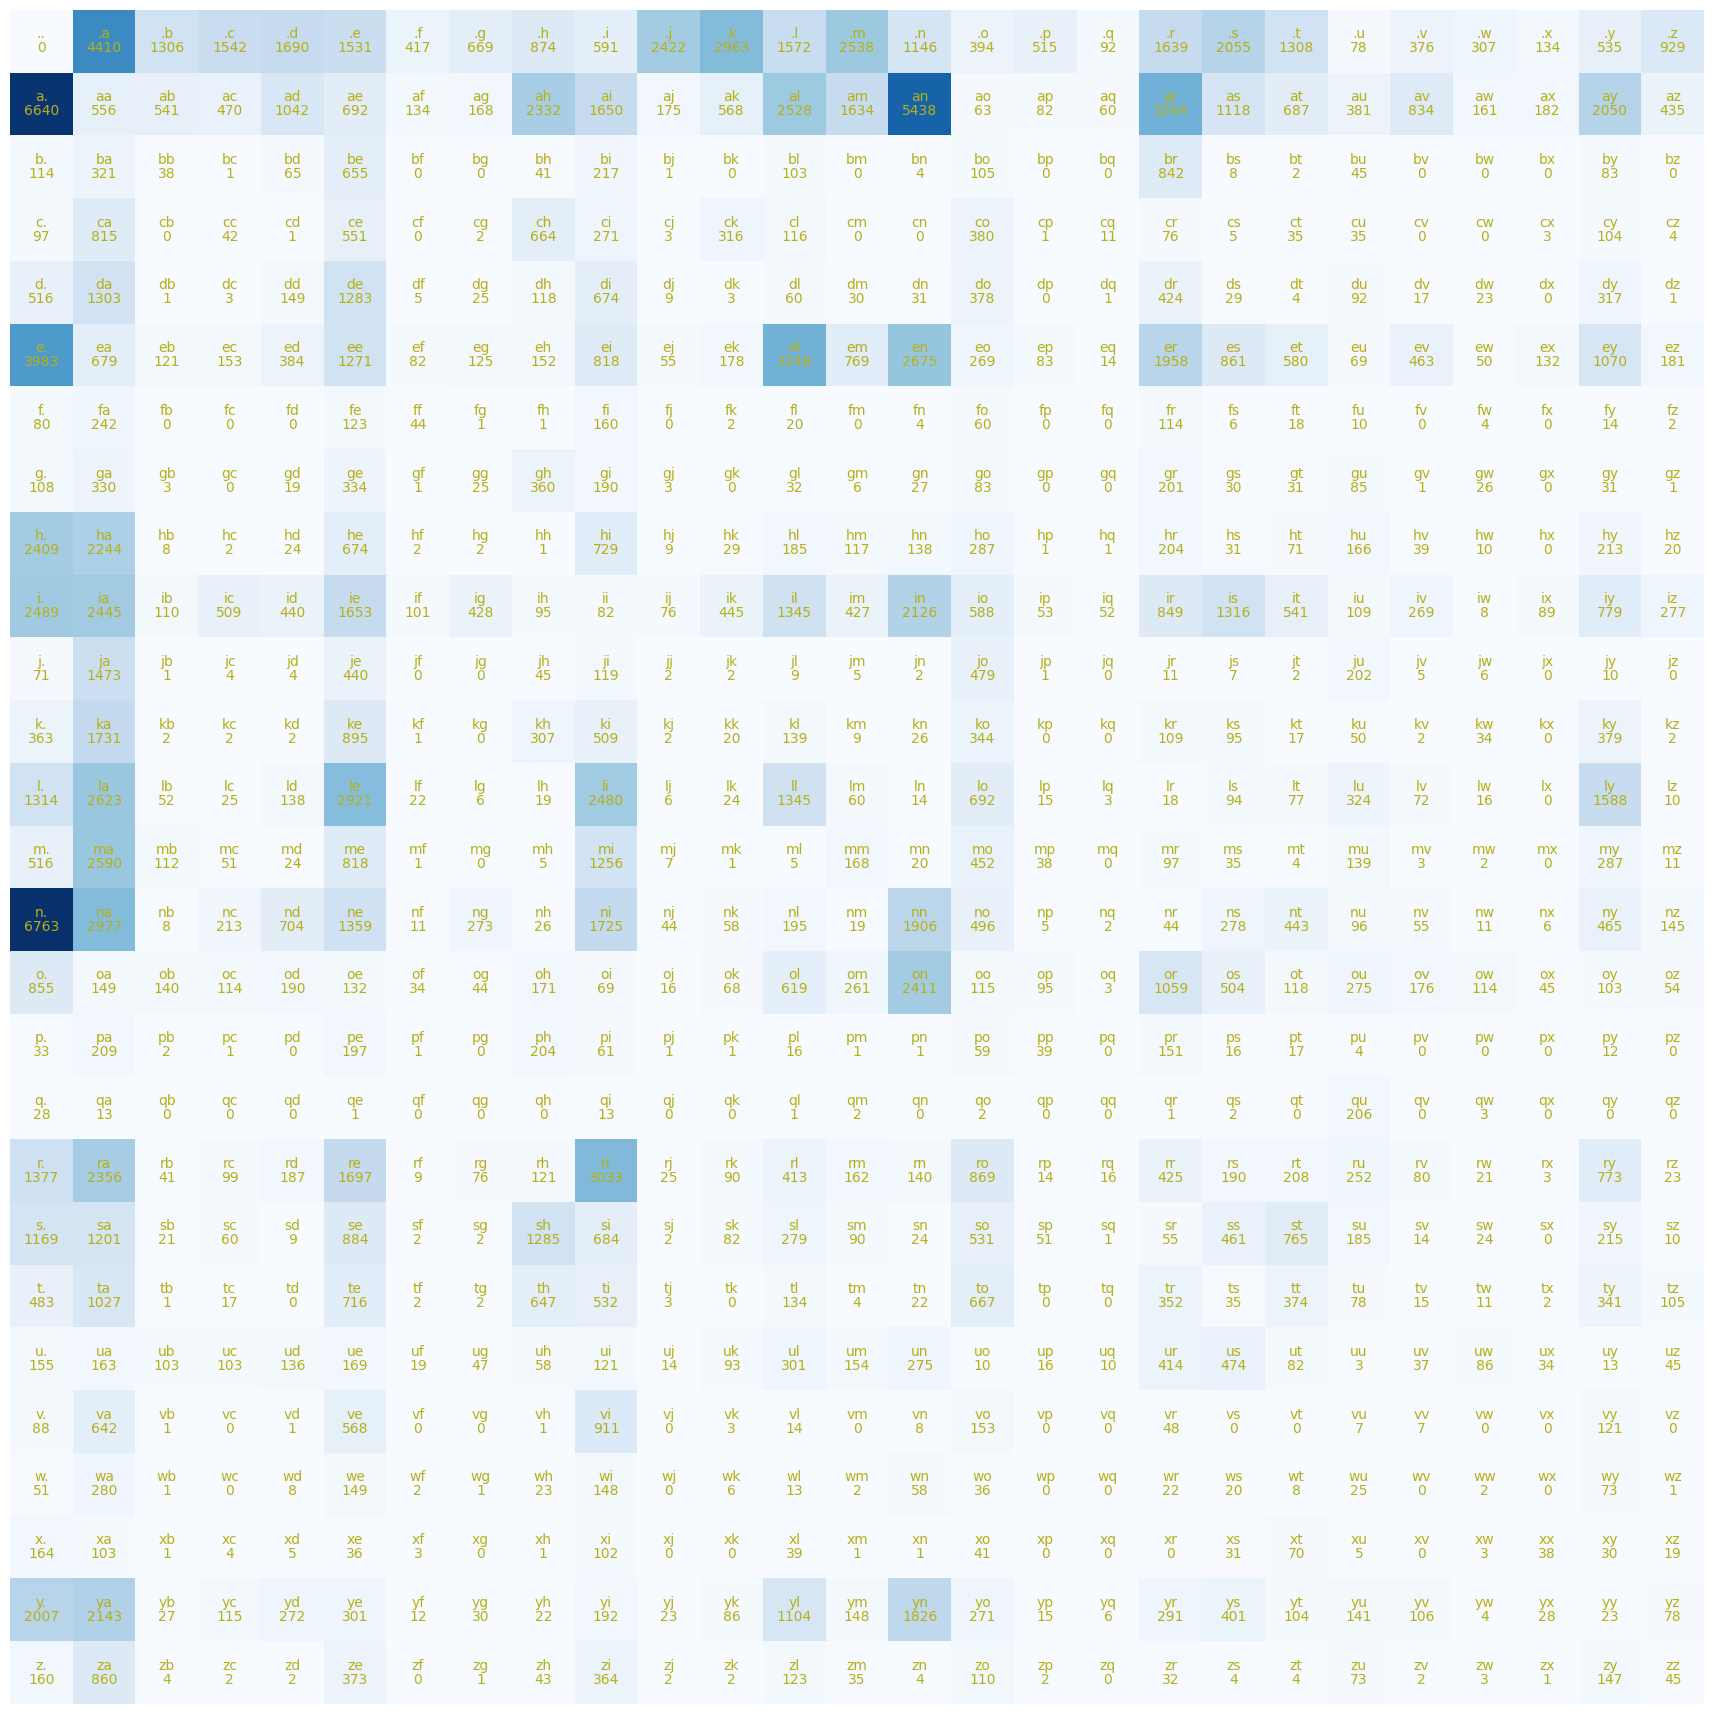

In [12]:
plt.figure(figsize = (22 , 22))
plt.axis('off')
plt.imshow(N , cmap = 'Blues')
for x in range(27):
  for y in range(27):
    currentCharString = int_to_char[x] + int_to_char[y]
    plt.text(y , x , currentCharString , ha = 'center' , va = 'bottom' , color = '#b5b019')
    plt.text(y , x , N[x , y].item() , ha = 'center' , va = 'top' , color = '#b5b019')

In [13]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [14]:
generator = torch.Generator().manual_seed(2147483647)
p = torch.rand(3 , generator = generator)
p /= p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [15]:
# Now we will pass this normal distribution into a multinomial to generate integers
# We will see that ~60% will be 0s, ~30% will be 1s and ~10% will be 2s
torch.multinomial(p , num_samples = 20 , replacement = True , generator = generator)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [16]:
p = N[0].float()
p /= p.sum()
p , p.sum()

(tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
         0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
         0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290]),
 tensor(1.))

In [17]:
idx = torch.multinomial(p , num_samples = 1 , replacement = True , generator = generator)
idx , int_to_char[idx.item()]

(tensor([26]), 'z')

In [18]:
seed = 2147483647
generator = torch.Generator().manual_seed(seed)
idx = 0

for i in range(25):
  name = ''
  while True:
    p = N[idx].float()
    p /= p.sum()
    idx = torch.multinomial(p , num_samples = 1 , replacement = True , generator = generator).item()
    name += int_to_char[idx]
    if idx == 0:
      break
  print(name)

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.
dgossmitan.
il.
le.
pann.
that.


In [19]:
N.shape

torch.Size([27, 27])

In [20]:
P = (N + 1).float() # We are adding a fake count of 1, because if there is any bigram whose count is 0, then the loss of that bigram will be infinity
P /= P.sum(dim = 1 , keepdims = True)

In [21]:
P.sum(dim = 1).shape

torch.Size([27])

In [22]:
P.sum(dim = 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [23]:
# Generating them , but now in more efficient manner
seed = 2147483647
generator = torch.Generator().manual_seed(seed)
idx = 0

for i in range(25):
  name = ''
  while True:
    p = P[idx, : ]
    idx = torch.multinomial(p , num_samples = 1 , replacement = True , generator = generator).item()
    name += int_to_char[idx]
    if idx == 0:
      break
  print(name)

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.
dgossmitan.
il.
le.
pann.
that.


We now need to define the loss <br/>
Loss : log likelihood <br/>

if we have probabilities a,b,c <br/>
then likelihood = a*b*c <br/>
then log likelihood = log(abc) = log(a) + log(b) + log(c) <br/>
log likelihood starts at 0 <br/>

if all probs are 1 then log likelihood = 0 <br/>
and if probs are lower then it goes more and more negative <br/>

so we need to invert this since low means good as loss

In [24]:
log_likelihood = 0.0
n = 0
for word in names[:3]:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = char_to_int[ch1]
        c = char_to_int[ch2]
        prob = P[r,c]
        # higher numbers are closer to zero
        #
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} : {logprob:.4f}')

nll = -log_likelihood
normalized_nll = nll/n
print(f"{nll=} {normalized_nll=}")

.e: 0.0478 : -3.0410
em: 0.0377 : -3.2793
mm: 0.0253 : -3.6753
ma: 0.3885 : -0.9454
a.: 0.1958 : -1.6305
.o: 0.0123 : -4.3965
ol: 0.0779 : -2.5526
li: 0.1774 : -1.7293
iv: 0.0152 : -4.1845
vi: 0.3508 : -1.0476
ia: 0.1380 : -1.9807
a.: 0.1958 : -1.6305
.a: 0.1376 : -1.9835
av: 0.0246 : -3.7041
va: 0.2473 : -1.3971
a.: 0.1958 : -1.6305
nll=tensor(38.8086) normalized_nll=tensor(2.4255)


In [25]:
"""
goal:
-> maximize likelihood of the data wrt model parameters (statistical modeling)
  OR
-> equivalent to maximizing log likelihood (log is monotonic)
  OR
-> equivalent to minimizing negative log likelihood
  OR
-> equivalent to minimizing the average negative log likelihood

upcoming:
the probabilities will be calculated by neural networks instead of using a lookup table and we've to reach the goal
"""

"\ngoal:\n-> maximize likelihood of the data wrt model parameters (statistical modeling)\n  OR\n-> equivalent to maximizing log likelihood (log is monotonic)\n  OR\n-> equivalent to minimizing negative log likelihood\n  OR\n-> equivalent to minimizing the average negative log likelihood\n\nupcoming:\nthe probabilities will be calculated by neural networks instead of using a lookup table and we've to reach the goal\n"

In [27]:
log_likelihood = 0.0
n = 0
for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = char_to_int[ch1]
        c = char_to_int[ch2]
        prob = P[r,c]
        # higher numbers are closer to zero
        #
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} : {logprob:.4f}')

nll = -log_likelihood
normalized_nll = nll/n
print(f"{nll=} {normalized_nll=}")

nll=tensor(559951.5625) normalized_nll=tensor(2.4544)
